# Solve Google Recaptcha v2

Below is code written and designed to solve https://recaptcha-demo.appspot.com/recaptcha-v2-checkbox-explicit.php


## Outstanding

- TODO fix fine tuning problem 
- TODO generalise a heuristic for converting words with numeric representation like [one, won, wan] -> 1 

In [3]:
%%capture --no-display
# Uncomment if necessary
!python3 -m pip install torch
!python3 -m pip install transformers
!python3 -m pip install datasets
!python3 -m pip install torchaudio
!python3 -m pip install sentencepiece
!python3 -m pip install soundfile
!python3 -m pip install librosa
!python3 -m pip install torchvision
!python3 -m pip install speechbrain
!python3 -m pip install matplotlib
!python3 -m pip install pydub
!python3 -m pip install warnings
!python3 -m pip install nltk
!python3 -m pip install jiwer
!python3 -m pip install pandas

In [4]:
# Generic
import matplotlib.pyplot as plt
from pydub import AudioSegment
import numpy as np
from IPython.display import Audio
import warnings
import pandas

# Audio analysis & ML
import torch
import torchaudio
from speechbrain.pretrained import SpectralMaskEnhancement
from transformers import Speech2TextProcessor, Speech2TextForConditionalGeneration
from transformers import pipeline
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from speechbrain.pretrained import WaveformEnhancement
import pickle
from transformers import Wav2Vec2Processor
from transformers import Wav2Vec2FeatureExtractor
from transformers import Wav2Vec2CTCTokenizer
from datasets import Dataset


In [65]:
# Helpers
# Wrap array extractor in function
def download_audio(file):
    audio = AudioSegment.from_file(file)
    samples = audio.get_array_of_samples()
    sample_rate = audio.frame_rate
    duration = audio.duration_seconds
    
    return np.array(samples, dtype=float), sample_rate, duration

Audio(download_audio('../data/recaptcha/adifferentpassionsfrom.wav')[0], rate = 32000)


# Enhancement Audio (file) -> Audio (sample array)

In [2]:
# Speech brain metricgan-plus-voicebank
def enhance_audio_metrican(path_to_file):
    # setup spectral enhancement from speechbrain
    enhance_model = SpectralMaskEnhancement.from_hparams("pretrained_models/metricgan-plus-voicebank")

    # Load and add fake batch dimension
    original_ = enhance_model.load_audio(path_to_file).unsqueeze(0)

    # Enhance
    enhanced_ = enhance_model.enhance_batch(original_, lengths=torch.tensor([1.]))

    return enhanced_ # This is 2 levels deep tensor [[s1, s2, ..., sn]]

Audio(enhance_audio_metrican('../data/recaptcha/adifferentpassionsfrom.wav'), rate = 16000)

In [3]:
from speechbrain.pretrained import WaveformEnhancement

# Speech brain metricgan-plus-voicebank
def enhance_audio_mimic(path_to_file):
    # setup spectral enhancement from speechbrain
    enhance_model = WaveformEnhancement.from_hparams("pretrained_models/mtl-mimic-voicebank")
    # enhanced = enhance_model.enhance_file(path_to_file)
    # Load and add fake batch dimension
    original_ = enhance_model.load_audio(path_to_file).unsqueeze(0)

    # Enhance
    enhanced_ = enhance_model.enhance_batch(original_, lengths=torch.tensor([1.]))

    return enhanced_ # This is 2 levels deep tensor [[s1, s2, ..., sn]]

Audio(enhance_audio_mimic('../data/recaptcha/adifferentpassionsfrom.wav'), rate = 16000)

# Automatic Speech Recognition Audio (sample) -> String

In [49]:
# Download pretrained models for use
# from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
# # Facebook Wav2Vec2Processor, Wav2Vec2ForCTC
# processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
# model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
# processor.save_pretrained('pretrained_models/facebook/processor/wav2vec2-base-960h')
# model.save_pretrained('pretrained_models/facebook/model/wav2vec2-base-960h')

# # Speech2TextForConditionalGeneration, Speech2TextProcessor
# model = Speech2TextForConditionalGeneration.from_pretrained("facebook/s2t-small-librispeech-asr")
# processor = Speech2TextProcessor.from_pretrained("facebook/s2t-small-librispeech-asr")
# processor.save_pretrained('pretrained_models/facebook/processor/s2t-small-librispeech-asr')
# model.save_pretrained('pretrained_models/facebook/model/s2t-small-librispeech-asr')


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# s2t-small-librispeech-asr
def transcribe_s2t(audio_sample, sample_rate=16000):
    # Instantiate model
    model = Speech2TextForConditionalGeneration.from_pretrained("pretrained_models/facebook/model/s2t-small-librispeech-asr")
    # Processor = Featurise + tokenise
    processor = Speech2TextProcessor.from_pretrained("pretrained_models/facebook/processor/s2t-small-librispeech-asr")
    inputs = processor(audio_sample, sampling_rate=sample_rate, return_tensors="pt")
    generated_ids = model.generate(inputs["input_features"], attention_mask=inputs["attention_mask"])
    # Transcribe
    transcription = processor.batch_decode(generated_ids)
    
    return [s.lower() for s in transcription]

# s2t-small-librispeech-asr
def transcribe_wave2vec(audio_sample, sample_rate=16000):
    # load model and tokenizer
    processor = Wav2Vec2Processor.from_pretrained("pretrained_models/facebook/processor/wav2vec2-base-960h")
    model = Wav2Vec2ForCTC.from_pretrained("pretrained_models/facebook/model/wav2vec2-base-960h")

    # tokenize
    input_values = processor(audio_sample, sampling_rate=sample_rate, return_tensors="pt", padding="longest").input_values  # Batch size 1

    # retrieve logits
    logits = model(input_values).logits

    # take argmax and decode
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    return [s.lower() for s in transcription]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print(transcribe_s2t(enhance_audio_metrican('../data/recaptcha/adifferentpassionsfrom.wav')[0], 16000))
    print(transcribe_wave2vec(enhance_audio_metrican('../data/recaptcha/adifferentpassionsfrom.wav')[0], 16000))


['the different passions from']
['different passions from']


In [28]:
def solve_captcha(path_to_file, enhancement_functions, asr_functions):
    
    transcriptions = []
    for enhance in enhancement_functions:
        enhanced_audio = enhance(path_to_file)
        for asr in asr_functions:
            transcription = asr(enhanced_audio[0])
            transcriptions.append(transcription)
    
    # Extract most common if competing this will take the first
    values, counts = np.unique(transcriptions, return_counts=True)
    ind = np.argmax(counts)
    most_common = values[ind]

    return most_common, transcriptions

solutions = solve_captcha('../data/recaptcha/adifferentpassionsfrom.wav', [enhance_audio_metrican, enhance_audio_mimic], [transcribe_s2t, transcribe_wave2vec])
solutions

('a different passions from',
 [['the different passions from'],
  ['different passions from'],
  ['a different passions from'],
  ['a different passions from']])

## Lets look at number recaptcha...

In [26]:
# Try on number data
number_data, rate_data, _ =  download_audio('../data/number-data/task100/task100_001.wav')
number_data, rate_data, _ =  download_audio('../data/number-data/task100/task100.wav')
Audio(number_data, rate=rate_data)

In [29]:
number_solutions = solve_captcha('../data/recaptcha/final data/task100/task100.wav', [enhance_audio_metrican, enhance_audio_mimic], [transcribe_s2t, transcribe_wave2vec])
number_solutions

('dura once five dura six five none seven six three',
 [['ville one five half if five none another thanks the'],
  ['vira once five vera six five none seven six three'],
  ['zero five vera fifty five none heaven thanks they'],
  ['dura once five dura six five none seven six three']])

As we can see, analysis must be done to convert these strings to most likely numbers

# Test on more data

In [42]:
from os import walk
root_path = '../data/recaptcha/v2/wav'
f = []
for (dirpath, dirnames, filenames) in walk(root_path):
    f.extend(filenames)
    break
labels = [i.replace('.wav', '') for i in f]
data_paths = [root_path + '/' + i + '.wav' for i in labels]

preds = []
for pth in data_paths:
    pred = solve_captcha(pth, [enhance_audio_metrican, enhance_audio_mimic], [transcribe_s2t, transcribe_wave2vec])[0]
    preds.append(pred)

/Users/lukacroote/Desktop/uni/project 1/breaking-captcha/Teams_T2_2022/Audio_CAPTCHA/.env/lib/python3.10/site-packages/transformers/models/speech_to_text/modeling_speech_to_text.py:561: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  input_lengths = (input_lengths - 1) // 2 + 1
/Users/lukacroote/Desktop/uni/project 1/breaking-captcha/Teams_T2_2022/Audio_CAPTCHA/.env/lib/python3.10/site-packages/transformers/generation_utils.py:1202: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config

In [53]:
# compare
from statistics import mean
import nltk
from nltk.translate import bleu
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4
from jiwer import wer


score_exact = []
score_bleu = []
score_wer = []
for i in range(len(preds)):
    actual = labels[i]
    pred = preds[i]
    score_exact.append(int(actual == pred))
    # score_bleu.append(bleu([actual], pred, smoothing_function=smoothie))
    score_wer.append(wer(actual, pred))

print('Accuracy: ', sum(score_exact) / len(score_exact))
print('Average word error rate (WER): ', mean(score_wer))
# plt.hist(score_wer)


Accuracy:  0.09523809523809523
Average word error rate (WER):  0.6637566137566138


In [55]:
list(zip(labels, preds))[:10]

[('positively charged sodium', 'positively charged sodium'),
 ('stiched together different pic', 'stitch together different pick'),
 ('very plush children can', 'very plash children'),
 ('been through hardships', 'fit you hard ships and'),
 ('mechanical system can', 'mechanical system canum'),
 ('awkward comment cards', 'the awkward comment cards'),
 ('ay hopefully like', 'eh and a wholeflly like'),
 ('a really good example', 'a rully good examp'),
 ('most prominent logical', 'most prominent logical c'),
 ('but ingredients for me', 'but in greedy answer me')]

### Comments:

We can see above that in many cases we are very close. The speech2text models often return incorrectly spelled words. Hence a captcha like: "at pragmatic works dot come" -> "a pragmetic works tot calm", the algorithms aim to spell the way it is pronounced. 

Also notice that the final word is often non-existant because in the audio clip it is actually clipped. However due to labeling being a human task the clipped audio is inferred even if slight heard.

In [35]:
# from os import walk

# f = []
# for (dirpath, dirnames, filenames) in walk('../data/recaptcha/v2'):
#     f.extend(filenames)
#     break
# # download_audio('../data/recaptcha/v2/a really good example.mp3')

# import subprocess
# for filename in f:
#     new = filename.replace('mp3', 'wav')
#     subprocess.call(['ffmpeg', '-i', '../data/recaptcha/v2/' + filename, '../data/recaptcha/v2/wav/' + new])

ffmpeg version 5.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 13.1.6 (clang-1316.0.21.2.5)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/5.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-videotoolbox -

## Fine Tune for numeric google recaptcha

Convert Audio -> Text -> digits

NOTE: This below section is **EXPERIMENTAL** it yields terrible results for some reason I have yet to figure out. 

This fine tuning is done following the [following method](https://huggingface.co/blog/fine-tune-wav2vec2-english)

In [42]:
# Collect Data
# First collect data
from os import walk
import os

digit_dict = {
    '0': 'zero'
    , '1': 'one'
    , '2': 'two'
    , '3': 'three'
    , '4': 'four'
    , '5': 'five'
    , '6': 'six'
    , '7': 'seven'
    , '8': 'eight'
    , '9': 'nine'  
}

root_path = '../data/recaptcha/numeric'
file_paths = []
labels = []
for path, currentDirectory, files in os.walk(root_path):
    for file in files:
        if file.find('_') < 0 and file.find('.wav') > -1: 
            labels.append(open(os.path.join(path, 'oracle')).readline().rstrip())
            file_paths.append(os.path.join(path, file))

label_words = []
for j in [list(i) for i in labels]:
    sublist = []
    for k in j:
        sublist.append(digit_dict[k])
    label_words.append(' '.join(sublist))

data = list(zip(file_paths, label_words))

In [51]:
# Enhance Data
# setup spectral enhancement from speechbrain
enhance_model = WaveformEnhancement.from_hparams("pretrained_models/mtl-mimic-voicebank")

In [52]:
# Enhance
data_enhanced = []
for dat in data:
    original_ = enhance_model.load_audio(dat[0]).unsqueeze(0)
    enhanced_ = enhance_model.enhance_batch(original_, lengths=torch.tensor([1.]))
    data_enhanced.append((enhanced_[0], dat[1]))

In [95]:
# save data
import pickle

with open('../data/recaptcha/numeric_enhanced_labeled.pickle', 'wb') as handle:
    pickle.dump(data_enhanced, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:
# import pickle

# with open('../data/recaptcha/numeric_enhanced_labeled.pickle', 'rb') as handle:
#     data_enhanced = pickle.load(handle)

In [87]:
all_text = " ".join([i[1] for i in data_enhanced])
vocab = list(set(all_text))
vocab_dict = {v: k for k, v in enumerate(vocab)}
# Make space explcicit
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
print(len(vocab_dict))

import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

18


In [ ]:
import pickle

with open('../data/recaptcha/numeric_enhanced_labeled.pickle', 'rb') as handle:
    data_enhanced = pickle.load(handle)

In [5]:
from transformers import Wav2Vec2Processor
from transformers import Wav2Vec2FeatureExtractor
from transformers import Wav2Vec2CTCTokenizer

# Tokenizer
tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")
# Feature extractor
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)
# Processor
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

# Convert to tensors
X = []
for i in [i[0] for i in data_enhanced]:
    t = torch.Tensor(i)
    t = processor(i, sampling_rate=16000).input_values[0]
    X.append(t)
Y = []
for i in [i[1] for i in data_enhanced]:
        with processor.as_target_processor():
                ids = processor(i).input_ids
        t = torch.Tensor(ids)
        Y.append(t)

In [20]:
from datasets import Dataset
ds = Dataset.from_dict({"input_values": X, "labels": Y}).with_format("torch")
ds = ds.train_test_split(0.3, shuffle=True)

tensor([15., 12., 11.,  0., 14., 10.,  3.,  5.,  8., 13., 10., 14.,  0., 13.,
        15., 15., 10., 14.,  6.,  5., 10.,  3.,  5.,  8., 13., 10.,  9., 12.,
         1., 10.,  5.,  7., 15., 10.,  9., 15.,  2., 15.,  7., 10.,  5.,  7.,
        15., 10.,  3., 12.,  2., 15.])
eight four three two four six one seven one five


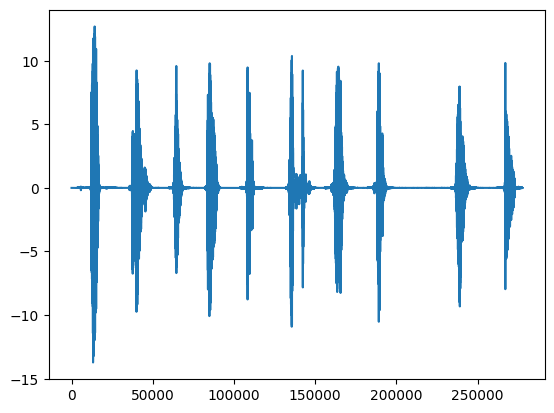

In [60]:
plt.plot(X[0])
print(Y[0])
print([i[1] for i in data_enhanced][0])

In [9]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch


In [10]:
# Initialise collator
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [12]:
# Training metric
from datasets import load_metric
wer_metric = load_metric("wer")

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [67]:
# Model
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base", 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
)

loading configuration file https://huggingface.co/facebook/wav2vec2-base/resolve/main/config.json from cache at /Users/lukacroote/.cache/huggingface/transformers/c7746642f045322fd01afa31271dd490e677ea11999e68660a92619ec7c892b4.ce1f96bfaf3d7475cb8187b9668c7f19437ade45fb9ceb78d2b06a2cec198015
/Users/lukacroote/Desktop/uni/project 1/breaking-captcha/Teams_T2_2022/Audio_CAPTCHA/.env/lib/python3.10/site-packages/transformers/configuration_utils.py:368: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Model config Wav2Vec2Config {
  "activation_dropout": 0.0,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForPreTraining"
  ],
  "attention_dropout": 0.1,

In [68]:
model.freeze_feature_extractor()

/Users/lukacroote/Desktop/uni/project 1/breaking-captcha/Teams_T2_2022/Audio_CAPTCHA/.env/lib/python3.10/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1618: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5.Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [69]:
# Training
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir='fine_tune_2',
  # group_by_length=True,
  # per_device_train_batch_size=16,
  # evaluation_strategy="steps",
  # num_train_epochs=30,
  # # fp16=True,
  # gradient_checkpointing=True, 
  # save_steps=500,
  # eval_steps=500,
  # logging_steps=500,
  # learning_rate=1e-4,
  # weight_decay=0.005,
  # warmup_steps=1000,
  # save_total_limit=2,
  # push_to_hub=False
)

from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=processor.feature_extractor,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [70]:
# Train
trainer.train()

/Users/lukacroote/Desktop/uni/project 1/breaking-captcha/Teams_T2_2022/Audio_CAPTCHA/.env/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 321
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 123
  0%|          | 0/123 [00:00<?, ?it/s]/Users/lukacroote/Desktop/uni/project 1/breaking-captcha/Teams_T2_2022/Audio_CAPTCHA/.env/lib/python3.10/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disab

{'train_runtime': 4484.9725, 'train_samples_per_second': 0.215, 'train_steps_per_second': 0.027, 'train_loss': 9.723097886496443, 'epoch': 3.0}


TrainOutput(global_step=123, training_loss=9.723097886496443, metrics={'train_runtime': 4484.9725, 'train_samples_per_second': 0.215, 'train_steps_per_second': 0.027, 'train_loss': 9.723097886496443, 'epoch': 3.0})

In [72]:
pred = trainer.predict(ds['test'], )
# trainer.compute_metrics()

***** Running Prediction *****
  Num examples = 138
  Batch size = 8
100%|██████████| 18/18 [02:19<00:00,  7.77s/it]


In [105]:
# print(len(pred[0]))
# pred.predictions[0][0]
# def compute_metrics(pred):
# pred_logits = pred.predictions[0][0]
pred_logits = pred.predictions
pred_ids = np.argmax(pred_logits, axis=-1)
pred_ids
# np.argmax(pred_logits, axis = -1)
# np.argmax([[1, 2, 3], [2, 3 , 4], [3, 5, 6]], axis=0)

pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

# pred_str = processor.batch_decode(pred_ids)
# # we do not want to group tokens when computing the metrics
# label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

# wer = wer_metric.compute(predictions=pred_str, references=label_str)

    # return {"wer": wer}

# compute_metrics(pred)

# processor.decode(ds['test'])
# processor.decode(ds['test'][2]['labels'])


array([[12, 12, 12, ...,  0,  0,  0],
       [12, 12, 12, ...,  0,  0,  0],
       [12, 12, 12, ...,  0,  0,  0],
       ...,
       [12, 12, 12, ..., 12, 12, 12],
       [12, 12, 12, ...,  0,  0,  0],
       [12, 12, 12, ...,  0,  0,  0]])

In [54]:
pred.label_ids[0]

array([14.,  0., 13., 15., 15., 10.,  7., 12.,  7., 15., 10., 15., 12.,
       11.,  0., 14., 10.,  4., 15., 13.,  5., 10.,  7., 12.,  7., 15.,
       10.,  9., 15.,  2., 15.,  7., 10., 14.,  6.,  5., 10.,  9., 15.,
        2., 15.,  7., 10.,  9., 15.,  2., 15.,  7., 10., 14.,  0., 13.,
       15., 15., 17., 17., 17.], dtype=float32)

Below shows something is happening that is not quite correct... reauires some investigation.

In [66]:

with torch.no_grad():
  logits = model(torch.tensor(ds["test"][:1]["input_values"])).logits

pred_ids = torch.argmax(logits, dim=-1)

# convert ids to tokens
" ".join(processor.tokenizer.convert_ids_to_tokens(pred_ids[0].tolist()))

/var/folders/5x/_13x32nj1_vbwmpgl57kzsxr0000gn/T/ipykernel_58580/683227652.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = model(torch.tensor(ds["test"][:1]["input_values"])).logits


'e e e e e e e e e e e e e e e e | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |